<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/InterpolationMissingDataFFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ucimlrepo

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [8]:
# fetch dataset
wine = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets

# metadata
print(wine.metadata)

# variable information
print(wine.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

In [15]:
test_index = np.random.randint(0,6497, size =10)

In [23]:
df = pd.concat([X,y], axis = 1)
train_df = df.drop(test_index)
test_df = df.iloc[test_index, :]
print(f"df size : {df.shape}")
print(f"train_df size : {train_df.shape}")
print(f"test_df size : {test_df.shape}")

df size : (6497, 12)
train_df size : (6487, 12)
test_df size : (10, 12)


In [42]:
X_train = train_df.drop(["residual_sugar"], axis = 1)
y_train = train_df["residual_sugar"]
X_test = test_df.drop(["residual_sugar"], axis = 1)
y_test = test_df["residual_sugar"]

print(f"feature train shape : {X_train.shape}")
print(f"target train shape : {y_train.shape}")
print(f"feature test shape : {X_test.shape}")
print(f"target train shape : {y_test.shape}")

feature train shape : (6487, 11)
target train shape : (6487,)
feature test shape : (10, 11)
target train shape : (10,)


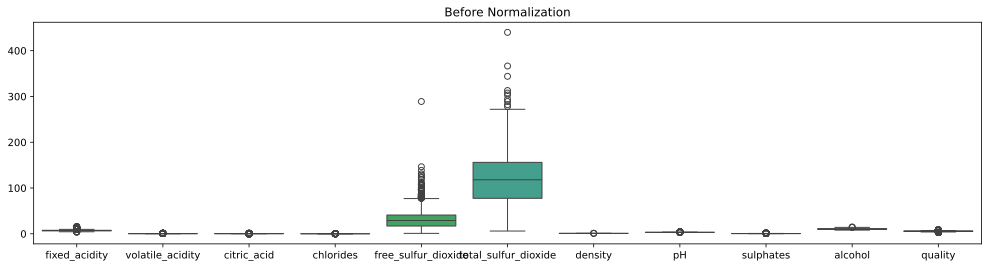

In [47]:
fig, ax = plt.subplots(1, figsize = (17,4))
ax = sns.boxplot(data = X_train)
ax.set_title("Before Normalization")
plt.show()

In [49]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [46]:
Xtrain_norm = scaler.transform(X_train)
Xtest_norm = scaler.transform(X_test)

<ipython-input-53-bcf0599f36e9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_train.columns)


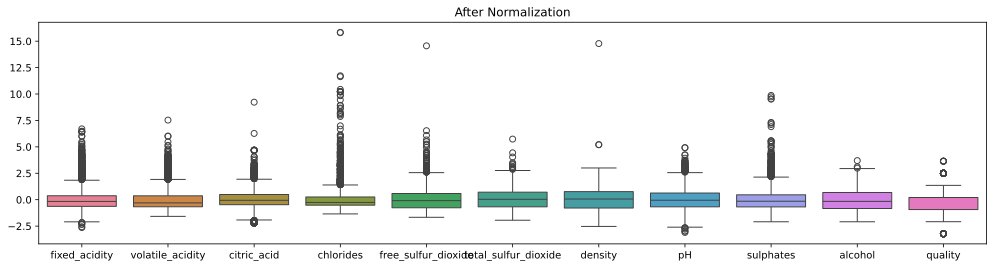

In [53]:
fig, ax = plt.subplots(1, figsize = (17,4))
ax = sns.boxplot(data = Xtrain_norm)
ax.set_title("After Normalization")
ax.set_xticklabels(X_train.columns)
plt.show()

In [105]:
X_torch_train = torch.tensor(Xtrain_norm).float()
X_torch_test = torch.tensor(Xtest_norm).float()
y_torch_train = torch.tensor(y_train.values).float().reshape((-1,1))
y_torch_test = torch.tensor(y_test.values).float().reshape((-1,1))

train_dataset = TensorDataset(X_torch_train,y_torch_train)
test_dataset = TensorDataset(X_torch_test,y_torch_test)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])

In [104]:
y_torch_test.reshape((-1,1))

tensor([[ 3.2000],
        [ 2.8000],
        [15.8000],
        [ 1.7000],
        [ 2.0000],
        [ 1.6000],
        [ 4.7000],
        [ 9.3000],
        [ 5.8000],
        [ 2.2000]])

In [89]:
def createModel() :

  model = nn.Sequential(
      nn.Linear(11, 32),
      nn.ReLU(),
      nn.Linear(32, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
  )

  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = .01)

  return model, lossfun, optimizer

In [113]:
model, lossfun, optimizer = createModel()

In [115]:
# test the model with one batch
model,lossfun,optimizer = createModel()

X,y = next(iter(train_dataloader))
yHat = model(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(55.2190, grad_fn=<MseLossBackward0>)


In [116]:
def functionToTrain(epochs) :
  trainLoss = torch.zeros(epochs)
  testLoss = torch.zeros(epochs)
  for epochi in range(epochs) :
    batchLoss = []
    for X, y in train_dataloader :
      yHat = model(X)
      loss = lossfun(yHat, y)
      batchLoss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    trainLoss[epochi] = np.mean(batchLoss)
    X_test, y_test = next(iter(test_dataloader))
    yHat = model(X_test)
    loss = lossfun(yHat, y_test)
    testLoss[epochi] = loss.item()

  return  trainLoss, testLoss


In [117]:
trainLoss, testLoss = functionToTrain(100)

In [124]:
X_test, y_test = next(iter(test_dataloader))
yHat = model(X_test)

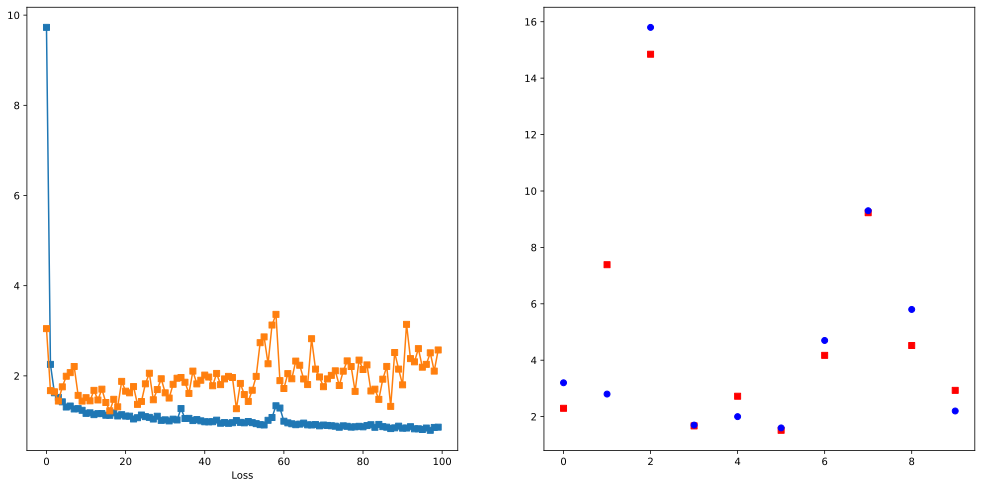

In [133]:
fig, ax = plt.subplots(1,2, figsize = (17,8))
ax[0].plot(trainLoss, "s-", label = "train")
ax[0].plot(testLoss, "s-", label = "test")
ax[0].set_xlabel("Loss")

ax[1].plot(yHat.detach(), "rs")
ax[1].plot(y_test, "bo")

In [146]:
yHat_list = yHat.detach().reshape(1,-1)[0].tolist()
y_test_list = y_test.reshape(1,-1)[0].tolist()
output = pd.DataFrame([i for i in zip(yHat_list, y_test_list)])

In [150]:
output

,0,1
0,2.295280,3.2
1,7.386496,2.8
2,14.848880,15.8
3,1.671682,1.7
4,2.722726,2.0
5,1.515679,1.6
6,4.172154,4.7
7,9.229934,9.3
8,4.520712,5.8
9,2.931424,2.2


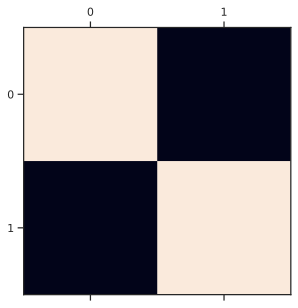

In [148]:
import matplotlib.pyplot as plt

plt.matshow(output.corr())
plt.show()

In [149]:
output.corr()

,0,1
0,1.000000,0.928529
1,0.928529,1.000000


tensor([[-0.1679],
        [-0.1271],
        [-0.0791],
        [-0.0938],
        [-0.0814],
        [-0.1844],
        [-0.2281],
        [-0.0757],
        [-0.0273],
        [-0.1730],
        [-0.1241],
        [-0.1325],
        [-0.0785],
        [-0.1272],
        [-0.0140],
        [-0.2100],
        [-0.0616],
        [-0.1675],
        [-0.1656],
        [-0.0700],
        [-0.1159],
        [-0.1350],
        [-0.3129],
        [-0.0945],
        [-0.1633],
        [-0.1297],
        [-0.2066],
        [-0.2057],
        [-0.0394],
        [-0.1385],
        [-0.1347],
        [-0.1659],
        [-0.0804],
        [-0.2185],
        [-0.0614],
        [-0.1108],
        [-0.2419],
        [-0.0919],
        [-0.1338],
        [-0.0824],
        [-0.0304],
        [-0.1831],
        [-0.1812],
        [-0.0345],
        [-0.0082],
        [-0.1551],
        [-0.0720],
        [-0.0904],
        [-0.0923],
        [-0.1914],
        [-0.0939],
        [-0.0729],
        [-0.